PU comparison

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os, yaml
sys.path.append('../lib')
sys.path.append('../analysis')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar
from array import array
from categoriesDef import categories

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Events
from DataFormats.FWLite import Handle

In [3]:
from prettytable import PrettyTable

In [4]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [5]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [6]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [7]:
def extractEff(fn):
    with open(fn) as f:
        for l in f.readlines():
            if not l.startswith('Eff'): continue
            return [float(l.split(' ')[1]), float(l.split(' ')[3])]
    return [None, None]

In [8]:
def extractNacc(fn):
    with open(fn) as f:
        for l in f.readlines():
            if not l.startswith('N_accepted'): continue
            return int(l.split(' ')[1])
    return None

# B2DstMu

## Data

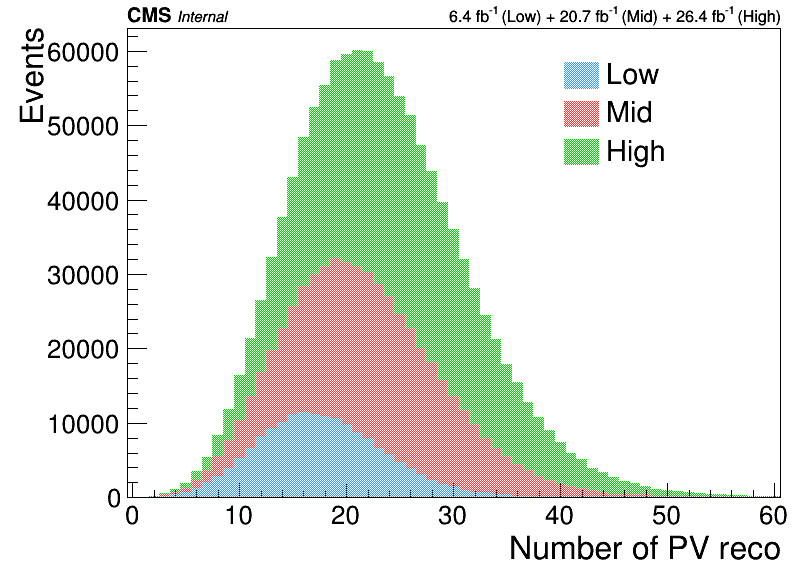

In [9]:
RDloc = '../data/cmsRD/skimmed/B2DstMu_200515_{}_corr.root'
lumiFiles = glob('../data/cmsRD/lumiReport/ParkingBPH*_Run2018D*_B2DstMu_200515_brilcalcPerTrigger.yaml')

# Get the lumi
lumis = []
for ic, cat in enumerate(['low', 'mid', 'high']):
    trg = categories[cat].trg
    k = categories[cat].name
    lumiInt = 0
    for fn in lumiFiles:
        d = yaml.load(open(fn, 'r'))
        for n, v in d.iteritems():
            if trg in n:
                lumiInt += v
    lumis.append('{:.1f} fb^{{-1}} ({})'.format(lumiInt, k))
CMS_lumi.integrated_lumi_string = ' + '.join(lumis)
                

# Fill the histo
leg = rt.TLegend(0.7, 0.7, 0.95, 0.9)
leg.SetBorderSize(0)
leg.SetTextFont(42)

colors = [rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]
hlist = []
stack = True
for ic, cat in enumerate(['Low', 'Mid', 'High']):
    t = ur.open(RDloc.format(cat))['Tevts']
    x = np.array(t.array('N_vtx'))
    h = create_TH1D(x, binning=[61, -0.5, 60.5], axis_title=['Number of PV reco', 'Events'])
    leg.AddEntry(h, cat, 'f')
    if stack:
        h.SetFillColor(colors[ic])
        h.SetFillStyle(3001)
        h.SetLineWidth(0)
        if ic > 0:
            h.Add(hlist[0])
    else:
        h.SetLineColor(colors[ic])
    hlist = [h] + hlist

c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
leg.Draw()

In [10]:
h = hlist[0].Clone('h0')
dataNorm = h.Integral()
h.Scale(1./h.Integral())
h.SetLineWidth(2)
h.SetLineColor(1)

In [11]:
#Value got from down in the NB
pCoeffFromMC = [-0.00268836, 0.93244846]

def probLinMulti(n, pCoeff=pCoeffFromMC, lamVal=[20, 35], lamFrac=[0.5,0.5]):
    out = 0
    for lam, frac in zip(lamVal, lamFrac):
        x = np.exp(-lam)/factorial(n)
        s = 0
        lastV = 1
        N = float(n)
        while lastV > 1e-2*s or N < 15:
            p = np.polyval(pCoeff, N)
            lastV = np.power(p, n)*np.power(1-p,N-n)*np.power(lam, N)/factorial(N-n)
            s += lastV
            N += 1
        out += frac*x*s 

    return out

In [12]:
def chi2LinMulti(inputs, npCoeff, nComp):
#     pCoeff = inputs[:npCoeff]
    lamVal = inputs[npCoeff:npCoeff+nComp]
    lamFrac = inputs[npCoeff+nComp:]
    chi2 = 0
    for i in range(1, h.GetNbinsX()+1):
        if h.GetBinContent(i) < 5e-3: continue
        aux = h.GetBinContent(i) - probLinMulti(i-1, lamVal=lamVal, lamFrac=lamFrac) #, pCoeff=pCoeff)
        aux /= h.GetBinError(i)
        chi2 += aux**2
    return chi2

In [13]:
# pCoeff = [-2.0e-04,  1.0e-03,  9.3e-01]
# pCoeff = [-4e-3, 0.96]
pCoeff = []


lamVal = [14., 21., 30., 42., 50.]
lamFrac = [0.10, 0.35, 0.37, 0.13, 0.03]
npCoeff, nComp = len(pCoeff), len(lamVal)
x0 = pCoeff+lamVal+lamFrac
print 'Start chi2: {:.1f}'.format(chi2LinMulti(x0, len(pCoeff), len(lamVal)))
res = minimize(chi2LinMulti, x0, args=(len(pCoeff), len(lamVal)), tol=1e-5)
print 'End chi2: {:.1f} ({:.1f})'.format(res.fun, res.fun/h.GetNbinsX())

Start chi2: 4148.5
End chi2: 61.9 (1.0)


In [14]:
print 'Coeff:', res.x[:len(pCoeff)]
outPois = res.x[npCoeff:]
for i in range(nComp):
    print 'lam={:.2f}, frac={:.3f}'.format(outPois[i], outPois[i+nComp])
print 'Norm: {:.3f}'.format(np.sum(outPois[nComp:]))

Coeff: []
lam=13.72, frac=0.102
lam=21.22, frac=0.355
lam=29.95, frac=0.371
lam=39.53, frac=0.138
lam=48.85, frac=0.030
Norm: 0.996


In [71]:
from scipy import stats
stats.chi2.cdf(62, 61-10)

0.8609061510125395

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
0.00000, 0.00000, 0.00001, 0.00005, 0.00016, 0.00138, 0.00195, 0.00294, 0.00444, 0.00644, 0.00885, 0.01153, 0.01432, 0.01715, 0.02002, 0.02298, 0.02603, 0.02911, 0.03207, 0.03472, 0.03686, 0.03838, 0.03927, 0.03958, 0.03945, 0.03901, 0.03835, 0.03753, 0.03655, 0.03537, 0.03397, 0.03232, 0.03046, 0.02842, 0.02627, 0.02409, 0.02196, 0.01992, 0.01802, 0.01627, 0.01468, 0.01322, 0.01189, 0.01068, 0.00956, 0.00853, 0.00759, 0.00674, 0.00596, 0.00526, 0.00463, 0.00407, 0.00359, 0.00316, 0.00279, 0.00247, 0.00219, 0.00196, 0.00176, 0.00160, 0.00146, 0.00134, 0.00125, 0.00118, 0.00112, 0.00107, 0.00104, 0.00101, 0.00099, 0.00098, 0.00002, 0.00002, 0.00001, 0.00001, 0.00000, 0.00000, 0.000

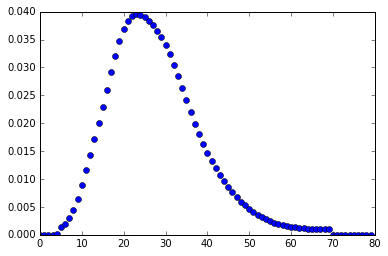

In [15]:
from scipy.stats import poisson
nVtx = []
prob = []
for n in range(80):
    if npCoeff:
        pCoeff = res.x[:npCoeff]
    else: pCoeff = pCoeffFromMC
    lamVal = res.x[npCoeff:npCoeff+nComp]
    lamFrac = res.x[npCoeff+nComp:]
    p = 0
    for lam, f in zip(lamVal, lamFrac):
        p += f*poisson.pmf(n, lam)
    prob.append(p)
    nVtx.append(n)

#Add some sort of flat pedestall to save the tails
prob = np.array(prob)
prob[5:70] += 1e-3
prob /= np.sum(prob)

plt.plot(nVtx, prob, 'o')
print nVtx
print ', '.join(['{:.5f}'.format(p) for p in prob])

hDeconv = create_TH1D(np.array([0]), h2clone=h)
for i in range(hDeconv.GetNbinsX()):
    hDeconv.SetBinContent(i+1, prob[i])
hDeconv.Scale(dataNorm)
hDeconv.SetLineColor(rt.kViolet-7)
hDeconv.SetFillStyle(0)
hDeconv.Sumw2(0)

In [19]:
MCsample = DSetLoader('B0_MuNuDmst_PUc0')
f = rt.TFile.Open(MCsample.skimmed_dir + '/Low_corr.root')
hSim = f.Get('hAllNvtx')
hSim.SetLineColor(rt.kOrange-3)
hSim.Scale(dataNorm/hSim.Integral())
hSim.Sumw2(0)
hSim.SetAxisRange(-0.5, 59.5, 'X')

df = rtnp.root2array(MCsample.skimmed_dir + '/High_corr.root')
hSim1 = create_TH1D(df['N_vtx'], h2clone=h, scale_histo=dataNorm/df['N_vtx'].shape[0])
hSim1.SetFillStyle(0)
hSim1.SetLabelColor(2)
hSim1.Sumw2(0)

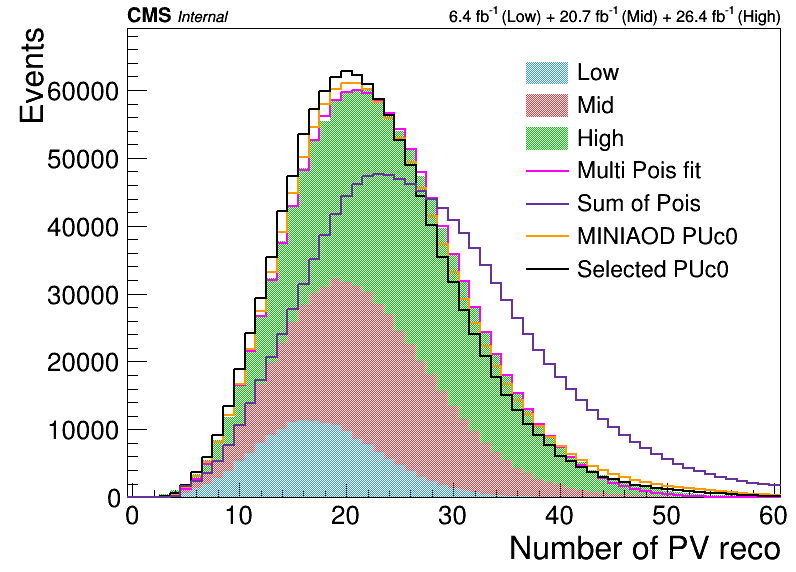

In [25]:
hFit = h.Clone('hFit')
hFit.Reset()
hFit.SetFillStyle(0)
hFit.SetLineColor(6)
hFit.SetLineStyle(1)
for i in range(1, hFit.GetNbinsX()+1):
    n = hFit.GetBinCenter(i)
    if npCoeff:
        pCoeff = res.x[:npCoeff]
    else: pCoeff = pCoeffFromMC
    lamVal = res.x[npCoeff:npCoeff+nComp]
    lamFrac = res.x[npCoeff+nComp:]
    hFit.SetBinContent(i, probLinMulti(n, pCoeff, lamVal, lamFrac))

hFit.Scale(dataNorm)
h_list_aux = [hFit, hSim, hSim1, hDeconv]

m = SetMaxToMaxHist(hlist+h_list_aux, 1.1)
c = drawOnCMSCanvas(CMS_lumi, hlist+h_list_aux, 'same')
leg1 = leg.Clone()
leg1.SetX1NDC(0.65)
leg1.SetY1NDC(0.5)
leg1.AddEntry(hFit, 'Multi Pois fit', 'l')
leg1.AddEntry(hDeconv, 'Sum of Pois', 'l')
leg1.AddEntry(hSim, 'MINIAOD PUc0', 'l')
leg1.AddEntry(hSim1, 'Selected PUc0', 'l')
leg1.Draw()

## MC comparison

In [26]:
CMS_lumi.integrated_lumi_string = ''

In [28]:
d = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU{}_10-2-3/'
skimFolder_template = d + 'ntuples_B2DstMu/skimmed/'

effCAND_template = d + 'ntuples_B2DstMu/effCAND.yaml'

t = PrettyTable()
t.field_names = ['PU', 'Low', 'Mid', 'High']
for PU in ['0', '20', '35']:
    eC_dic = yaml.load(open(effCAND_template.format(PU), 'r'))
    nMINIAOD = int(eC_dic['nTotMINIAOD'])
    leff = []
    for cat in ['Low', 'Mid', 'High']:
        fn = skimFolder_template.format(PU) + cat
        n = extractNacc(fn +'_corr.log')
        leff.append(getEff(n, nMINIAOD))
    t.add_row([PU] + ['{:.3f}+/-{:.3f}%'.format(100*float(e), 100*float(de)) for e, de in leff])
print 'MINIAOD -> Accepted selection efficiency'
print t

MINIAOD -> Accepted selection efficiency
+----+----------------+----------------+----------------+
| PU |      Low       |      Mid       |      High      |
+----+----------------+----------------+----------------+
| 0  | 0.661+/-0.003% | 0.491+/-0.002% | 0.503+/-0.002% |
| 20 | 0.532+/-0.001% | 0.407+/-0.001% | 0.439+/-0.001% |
| 35 | 0.476+/-0.004% | 0.376+/-0.004% | 0.403+/-0.004% |
+----+----------------+----------------+----------------+


In [30]:
d = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU{}_10-2-3/'
d += 'ntuples_B2DstMu/skimmed/'

t = PrettyTable()
t.field_names = ['PU', 'Low', 'Mid', 'High']
dMC = {}
for PU in ['0', '20', '35']:
    leff = []
    for cat in ['Low', 'Mid', 'High']:
        fn = d.format(PU) + cat
        leff.append(extractEff(fn + '_corr.log'))

        dMC[cat+PU] = rtnp.root2array(fn+'_corr.root')
    t.add_row([PU] + ['{:.2f}+/-{:.2f}%'.format(float(e), float(de)) for e, de in leff])
print 'Skimming selection efficiency'
print t

Skimming selection efficiency
+----+---------------+---------------+---------------+
| PU |      Low      |      Mid      |      High     |
+----+---------------+---------------+---------------+
| 0  | 24.66+/-0.08% | 18.30+/-0.07% | 18.76+/-0.07% |
| 20 | 23.33+/-0.04% | 17.84+/-0.03% | 19.24+/-0.03% |
| 35 | 22.70+/-0.17% | 17.91+/-0.15% | 19.21+/-0.16% |
+----+---------------+---------------+---------------+


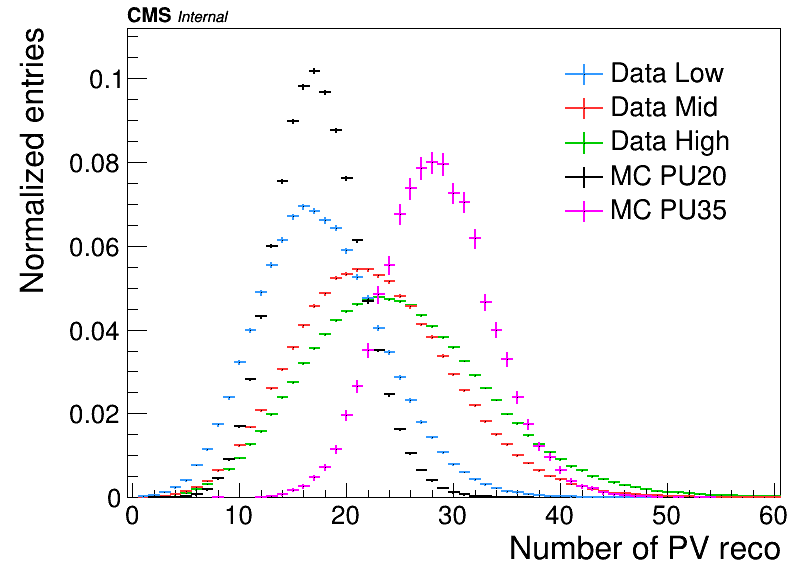

In [31]:
# Compare with data

RDloc = '../data/cmsRD/skimmed/B2DstMu_200515_{}_corr.root'

# Fill the histo
leg = rt.TLegend(0.7, 0.6, 0.97, 0.9)
leg.SetBorderSize(0)
leg.SetTextFont(42)

colors = [rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]
hlist = []
for ic, cat in enumerate(['Low', 'Mid', 'High']):
    t = ur.open(RDloc.format(cat))['Tevts']
    x = np.array(t.array('N_vtx'))
    h = create_TH1D(x, binning=[61, -0.5, 60.5], 
                    axis_title=['Number of PV reco', 'Normalized entries'], 
                    scale_histo=1./x.shape[0])
    h.SetLineColor(colors[ic])
    leg.AddEntry(h, 'Data '+cat, 'lep')
    hlist = [h] + hlist

x = dMC['Low20']['N_vtx']
h = create_TH1D(x, binning=[61, -0.5, 60.5], 
                scale_histo=1./x.shape[0])
h.SetLineColor(1)
leg.AddEntry(h, 'MC PU20', 'lep')
hlist.append(h)

x = dMC['High35']['N_vtx']
h = create_TH1D(x, binning=[61, -0.5, 60.5], 
                scale_histo=1./x.shape[0])
h.SetLineColor(6)
leg.AddEntry(h, 'MC PU35', 'lep')
hlist.append(h)

m = SetMaxToMaxHist(hlist)
c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
leg.Draw()

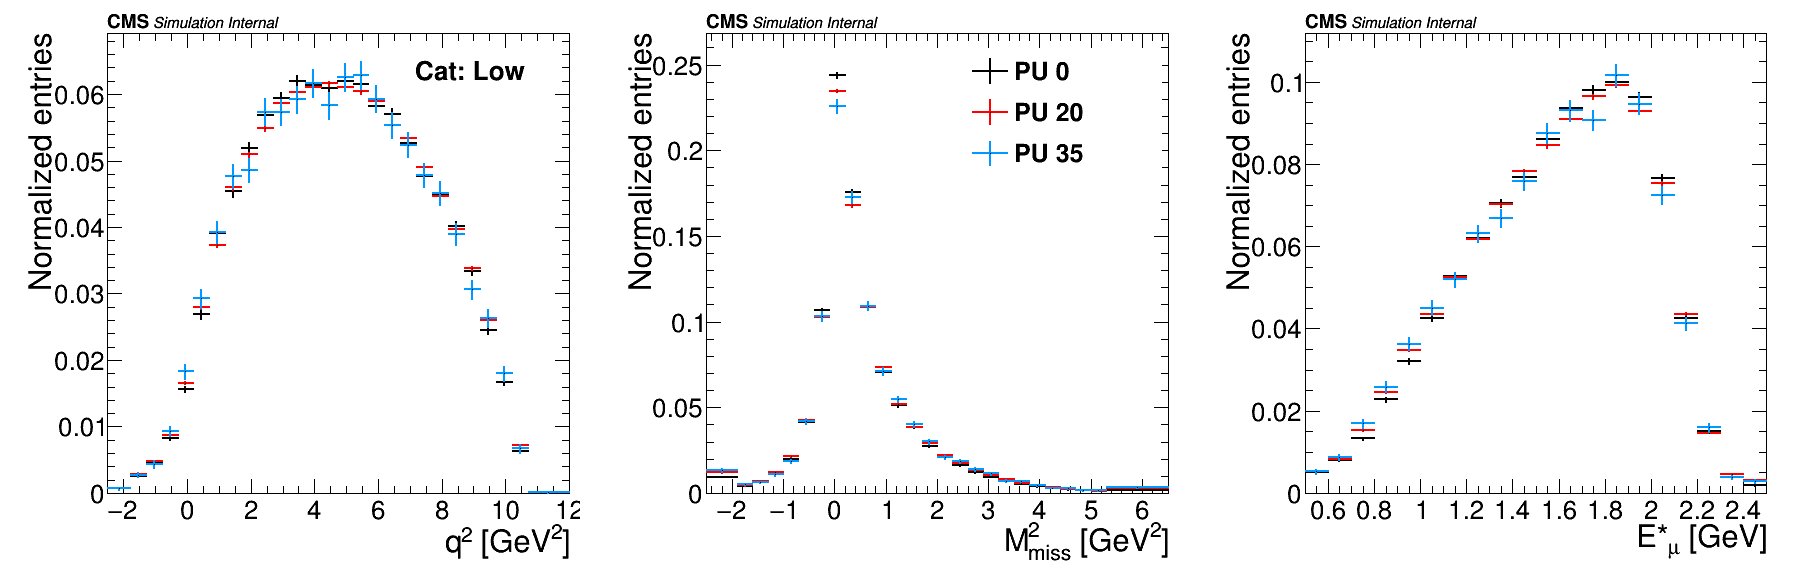

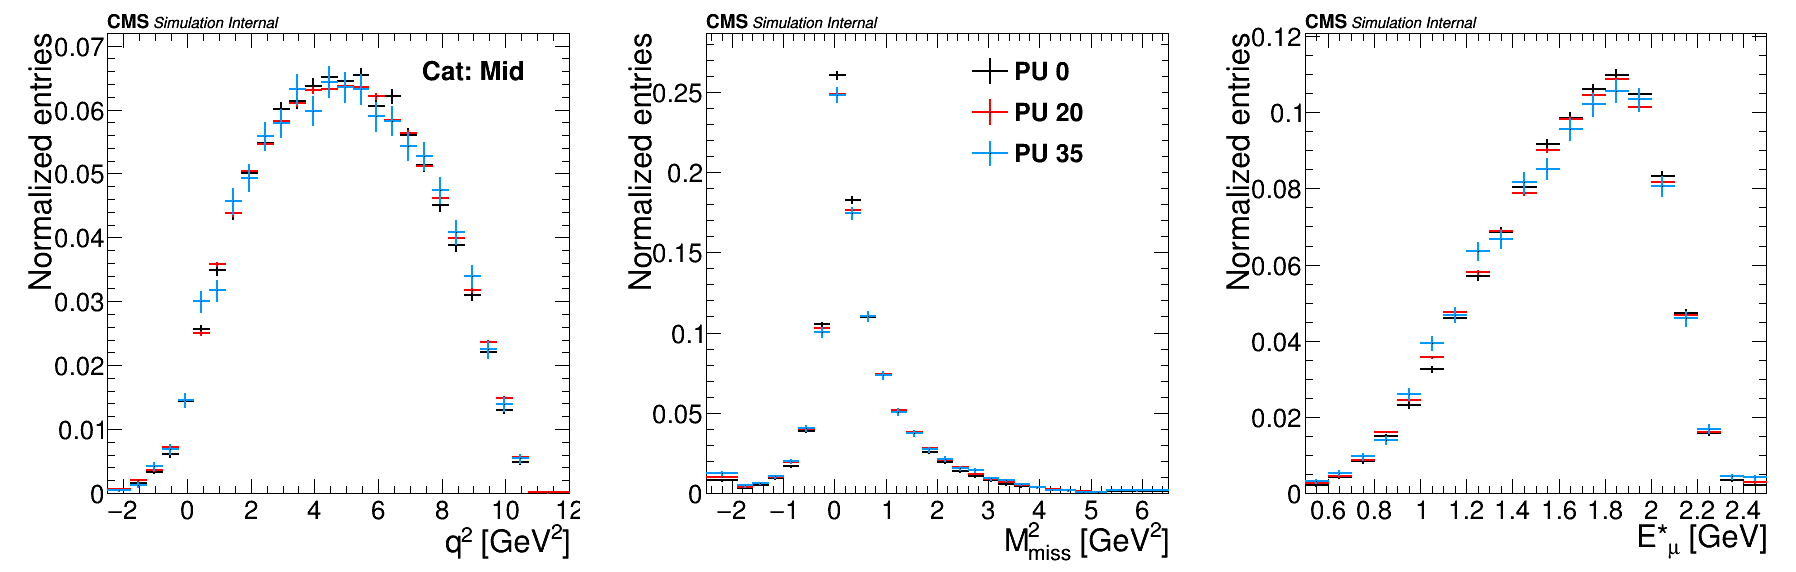

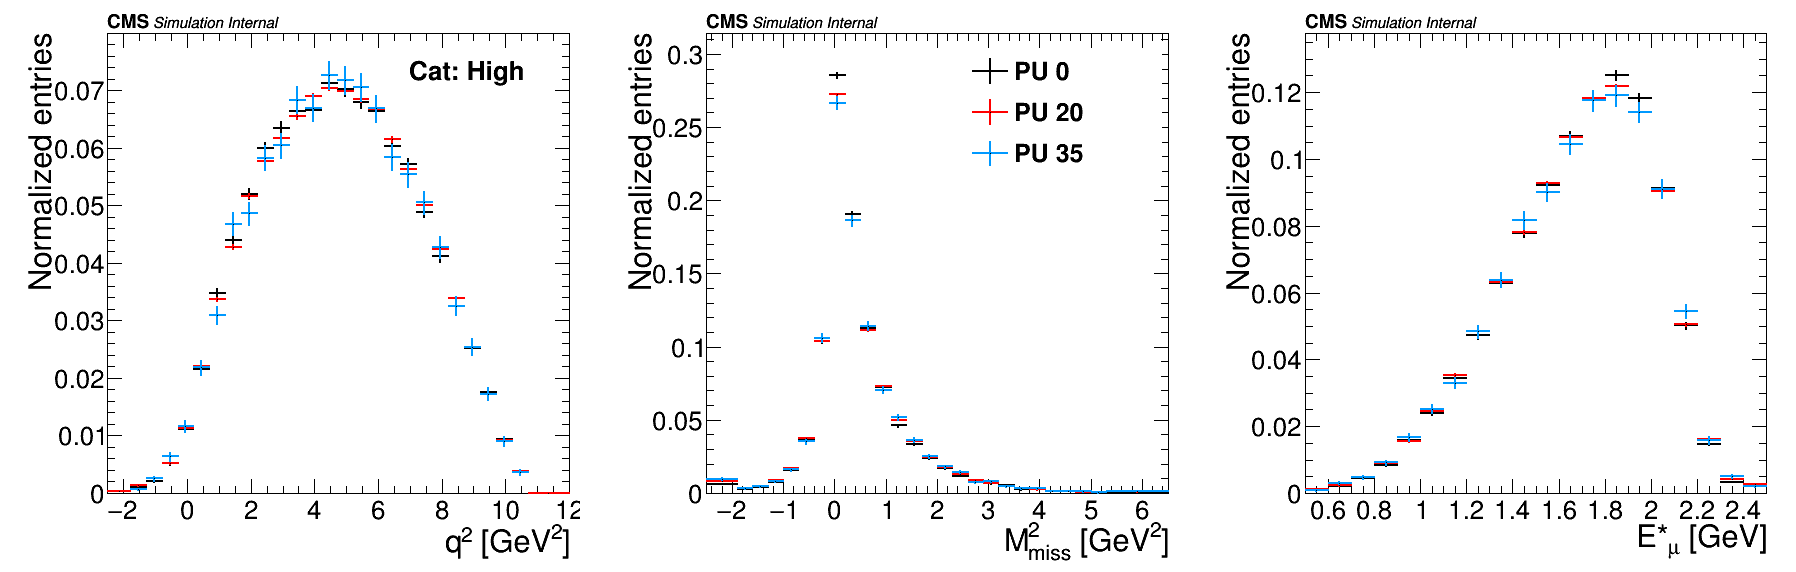

In [33]:
donotdelete = []
CMS_lumi.extraText = 6*' '+'Simulation Internal'
for cat in ['Low', 'Mid', 'High']:
    h0q2 =  create_TH1D(dMC[cat+'0']['q2'], name='h0q2'+cat, title='', 
                        axis_title=['q^{2} [GeV^{2}]', 'Normalized entries'],
                        binning=array('d', [-2.5] + list(np.arange(-1.8, 11, 0.5)) + [12] ),
                        scale_histo=1./len(dMC[cat+'0']['q2']),
                        opt='overflow+underflow'
                       )
    h20q2 =  create_TH1D(dMC[cat+'20']['q2'], name='h20q2'+cat, title='', 
                        binning=h0q2.binning,
                        scale_histo=1./len(dMC[cat+'20']['q2']),
                         opt='overflow+underflow'
                       )
    h20q2.SetLineColor(2)
    
    h35q2 =  create_TH1D(dMC[cat+'35']['q2'], name='h35q2'+cat, title='', 
                        binning=h0q2.binning,
                        scale_histo=1./len(dMC[cat+'35']['q2']),
                         opt='overflow+underflow'
                       )
    h35q2.SetLineColor(rt.kAzure+7)
    
    h0M =  create_TH1D(dMC[cat+'0']['M2_miss'], name='h0M'+cat, title='', 
                        axis_title=['M^{2}_{miss} [GeV^{2}]', 'Normalized entries'],
                        binning=array('d', [-2.5] + list(np.arange(-1.9, 5.5, 0.3)) + [6.5] ),
                        scale_histo=1./len(dMC[cat+'0']['q2']),
                       opt='overflow+underflow'
                       )
    h20M =  create_TH1D(dMC[cat+'20']['M2_miss'], name='h20M'+cat, title='', 
                        binning=h0M.binning,
                        scale_histo=1./len(dMC[cat+'20']['q2']),
                        opt='overflow+underflow'
                       )
    h20M.SetLineColor(2)
    
    h35M =  create_TH1D(dMC[cat+'35']['M2_miss'], name='h35M'+cat, title='', 
                        binning=h0M.binning,
                        scale_histo=1./len(dMC[cat+'35']['q2']),
                        opt='overflow+underflow'
                       )
    h35M.SetLineColor(rt.kAzure+7)
    
    h0E =  create_TH1D(dMC[cat+'0']['Est_mu'], name='h0E'+cat, title='', 
                        axis_title=['E*_{#mu} [GeV]', 'Normalized entries'],
                        binning=[20, 0.50, 2.500],
                        scale_histo=1./len(dMC[cat+'0']['q2']),
                       opt='overflow+underflow'
                       )
    h20E =  create_TH1D(dMC[cat+'20']['Est_mu'], name='h20E'+cat, title='', 
                        binning=h0E.binning,
                        scale_histo=1./len(dMC[cat+'20']['q2']),
                        opt='overflow+underflow'
                       )
    h20E.SetLineColor(2)
    
    h35E =  create_TH1D(dMC[cat+'35']['Est_mu'], name='h35E'+cat, title='', 
                        binning=h0E.binning,
                        scale_histo=1./len(dMC[cat+'35']['q2']),
                        opt='overflow+underflow'
                       )
    h35E.SetLineColor(rt.kAzure+7)
    
    c = rt.TCanvas('c'+cat, 'c'+cat, 50, 50, 1800, 600)
    c.SetTickx(0)
    c.SetTicky(0)
    c.Divide(3)
    
    pad = c.cd(1)
    SetMaxToMaxHist([h0q2, h20q2, h35q2])
    h0q2.Draw()
    h20q2.Draw('SAME')
    h35q2.Draw('SAME')
    CMS_lumi.CMS_lumi(pad, -1, 0)
    text = rt.TText(0.9, 0.9, 'Cat: '+cat)
    text.SetTextAlign(33)
    text.SetNDC()
    text.Draw()
    
    pad = c.cd(2)
    SetMaxToMaxHist([h0M, h20M, h35M])
    h0M.Draw()
    h20M.Draw('SAME')
    h35M.Draw('SAME')
    CMS_lumi.CMS_lumi(pad, -1, 0)
    leg = rt.TLegend(0.62, 0.7, 0.97, 0.92)
    leg.AddEntry(h0M, 'PU 0', 'lep')
    leg.AddEntry(h20M, 'PU 20', 'lep')
    leg.AddEntry(h35M, 'PU 35', 'lep')
    leg.SetBorderSize(0)
    leg.Draw()
    
    pad = c.cd(3)
    SetMaxToMaxHist([h0E, h20E, h35E])
    h0E.Draw()
    h20E.Draw('SAME')
    h35E.Draw('SAME')
    CMS_lumi.CMS_lumi(pad, -1, 0)
    
    donotdelete.append([c, leg, text, h0q2, h20q2, h35q2, h0M, h20M, h35M, h0E, h20E, h35E])
    
    c.Draw()

In [35]:
tMC20_ntuples = rt.TChain('outA/Tevts')
for f in glob(d.format(20).replace('skimmed/', 'out_*.root')):
    tMC20_ntuples.Add(f)

[<ROOT.TH1D object ("h20N") at 0xcdf3ab0>]
[<ROOT.TH1D object ("h20N") at 0xcdf3ab0>, <ROOT.TH1D object ("h20Nn") at 0xcdd2e10>]
[<ROOT.TH1D object ("h20N") at 0xcdf3ab0>, <ROOT.TH1D object ("h20Nn") at 0xcdd2e10>]
[<ROOT.TH1D object ("h20N") at 0xcdf3ab0>, <ROOT.TH1D object ("h20Nn") at 0xcdd2e10>, <ROOT.TH1D object ("hAllNvtx") at 0xcccf090>]


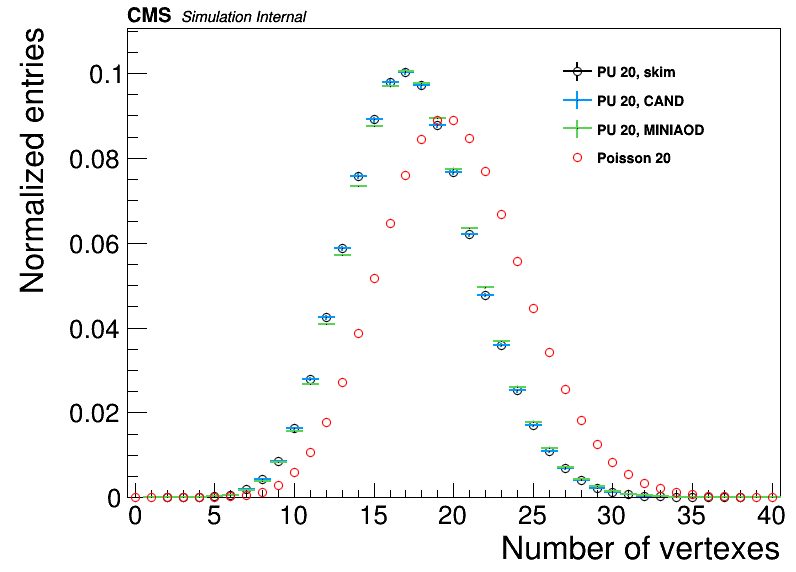

In [57]:
from scipy.stats import poisson
leg = rt.TLegend(0.7, 0.7, 0.9, 0.9)
leg.SetBorderSize(0)

h20N =  create_TH1D(dMC[cat+'20']['N_vtx'], name='h20N', title='', 
                    axis_title=['Number of vertexes', 'Normalized entries'],
                    binning=[41, -0.5, 40.5],
                    scale_histo='norm'
                   )
h20N.SetMarkerStyle(4)
h20N.SetMarkerColor(1)
leg.AddEntry(h20N, 'PU 20, skim', 'lep')
hl = [h20N]
print hl

h20Nn = h20N.Clone('h20Nn')
tMC20_ntuples.Project('h20Nn', 'N_vertexes', '')
h20Nn.Scale(1./h20Nn.Integral())
h20Nn.SetLineColor(rt.kAzure+7)
h20Nn.SetMarkerStyle(1)
leg.AddEntry(h20Nn, 'PU 20, CAND', 'lep')
hl.append(h20Nn)
print hl

d = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/'
d += 'ntuples_B2DstMu/skimmed/Low_corr.root'
faux1 = rt.TFile.Open(d, 'READ')
print hl
h20NM = faux1.Get('hAllNvtx')
h20NM.Scale(1./h20NM.Integral())
h20NM.SetLineColor(8)
leg.AddEntry(h20NM, 'PU 20, MINIAOD', 'lep')
hl.append(h20NM)
print hl

h20N_id = h20Nn.Clone('id')
for i in range(1, h20N_id.GetNbinsX()+1):
    h20N_id.SetBinContent(i, poisson.pmf(i-1, 20))
h20N_id.SetLineWidth(0)
h20N_id.SetMarkerStyle(4)
h20N_id.SetMarkerColor(2)
leg.AddEntry(h20N_id, 'Poisson 20', 'lep')
hl.append(h20N_id)

SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()

### Try to understand the distribution

In [58]:
def probLin(n, pCoeff=[-4e-3, 0.96], lam=20):
    x = np.exp(-lam)/factorial(n)
    
    s = 0
    lastV = 1
    N = float(n)
    while lastV > 1e-2*s or N < 15:
        p = np.polyval(pCoeff, N)
        lastV = np.power(p, n)*np.power(1-p,N-n)*np.power(lam, N)/factorial(N-n)
        s += lastV
        N += 1
    return x*s  

In [62]:
def chi2Lin(p):
    chi2 = 0
    for i in range(1, h20N.GetNbinsX()+1):
        if h20N.GetBinContent(i) < 5e-3: continue
        aux = h20N.GetBinContent(i) - probLin(i-1, p)
        aux /= h20N.GetBinError(i)
        chi2 += aux**2
    return chi2

In [63]:
# x0 = [-2.0e-04,  1.0e-03,  9.3e-01]
x0 = [-4e-3, 0.96]
print 'Start:',chi2Lin(x0)
res = minimize(chi2Lin, x0, tol=1e-5)
print 'End:', res.fun
print res.x

Start: 659.3414676755274


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scipy/1.1.0/lib/python2.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


End: 51.77851104869371
[-0.00243316  0.92181613]


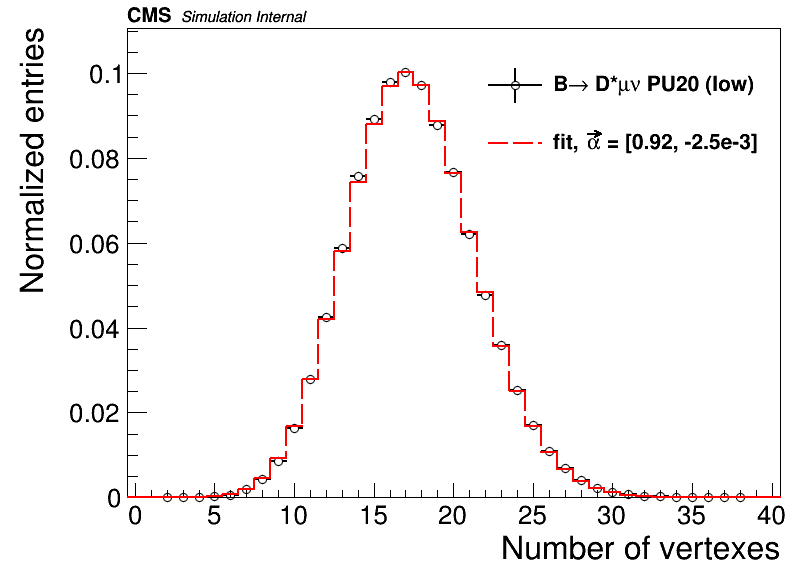

In [68]:
hFit = h20NM.Clone('hFit')
hFit.Reset()
hFit.SetLineColor(2)
for i in range(1, hFit.GetNbinsX()+1):
    n = hFit.GetBinCenter(i)
    hFit.SetBinContent(i, probLin(n, res.x))

hFit.SetLineStyle(9)
leg = rt.TLegend(0.6, 0.7, 0.98, 0.9)
leg.SetBorderSize(0)
leg.AddEntry(h20N, 'B#rightarrow D*#mu#nu PU20 (low)', 'lep')
leg.AddEntry(hFit, 'fit, #vec{#alpha} = [0.92, -2.5e-3]', 'l')
    
h20NM.SetXTitle('Number of vertexes')
c =  drawOnCMSCanvas(CMS_lumi, [h20N, hFit], 'same')
leg.Draw()

In [69]:
from scipy import stats
stats.chi2.cdf(51, 35)

0.9605743486765533

# B2JspiKst

# Load data

In [ ]:
dataDir = '../data/cmsMC_private/'
dataDir += 'BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3'
datasets_loc = glob(dataDir + '/ntuples_B2JpsiKst/out_CAND_*.root')

Tmc20 = rt.TChain('outA/Tevts')
for floc in datasets_loc:
    Tmc20.Add(floc)

print 'N evts: {:.0f}'.format(Tmc20.GetEntries())

In [ ]:
dataDir = '../data/cmsMC_private/'
dataDir += 'BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU0_10-2-3'
datasets_loc = glob(dataDir + '/ntuples_B2JpsiKst/out_CAND_*.root')

Tmc0 = rt.TChain('outA/Tevts')
for floc in datasets_loc:
    Tmc0.Add(floc)

print 'N evts: {:.0f}'.format(Tmc0.GetEntries())

In [ ]:
datasets_loc = glob('../data/cmsRD/ParkingBPH1/*2018C-*B2JpsiKst_200124_CAND.root')
TrdC = rt.TChain('outA/Tevts')
for floc in datasets_loc:
    TrdC.Add(floc)

print 'N evts: {:.0f}'.format(TrdC.GetEntries())

# Plots

In [ ]:
def plot(var, binning, cut_str='', axis_title=['', ''], leg_loc=[0.7, 0.7, 0.8, 0.9]):
    h1 = create_TH1D(np.zeros(0), name='h1', title='RD', axis_title=axis_title, binning=binning)
    TrdC.Project('h1', var, cut_str)

    h2 = create_TH1D(np.zeros(0), name='h2', title='MC 0', binning=binning)
    Tmc0.Project('h2', var, cut_str)
    
    h3 = create_TH1D(np.zeros(0), name='h3', title='MC 20', binning=binning)
    Tmc20.Project('h3', var, cut_str)
    
    leg = rt.TLegend(leg_loc[0], leg_loc[1], leg_loc[2], leg_loc[3])
    leg.SetBorderSize(0)
    h_list = [h1, h2, h3]
    colors = [rt.kBlack, rt.kRed, rt.kBlue]
    
    for i, h in enumerate(h_list):
        h.Sumw2()
        h.Scale(1./h.Integral())
        h.SetLineColor(colors[i])
        leg.AddEntry(h, h.GetTitle(), 'lep')

    SetMaxToMaxHist(h_list)
    c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
    c.SetRightMargin(0.15)
    c.dnd = [h_list, leg]
    leg.Draw()
    c.Draw()

    return c

In [ ]:
c = plot('N_vertexes', [50, 0.5, 50.5], '', axis_title=['N_{vtx}', 'Norm.'])

In [ ]:
c = plot('N_vertexes', [50, 0.5, 50.5], 'Sum$(trgMu_HLT_Mu12_IP6)>0', axis_title=['N_{vtx}', 'Norm.'])

In [ ]:
c = plot('N_vertexes', [50, 0.5, 50.5], 'Sum$(trgMu_HLT_Mu9_IP6)>0', axis_title=['N_{vtx}', 'Norm.'])

In [ ]:
c = plot('N_vertexes', [50, 0.5, 50.5], 'Sum$(trgMu_HLT_Mu7_IP4)>0', axis_title=['N_{vtx}', 'Norm.'])

In [ ]:
c = plot('n_B', [20, 0.5, 20.5], 'Sum$(trgMu_HLT_Mu12_IP6)>0', axis_title=['n_{B}', 'Norm.'])
c.SetLogy()

In [ ]:
c = plot('n_B', [20, 0.5, 20.5], 'Sum$(trgMu_HLT_Mu7_IP4)>0', axis_title=['n_{B}', 'Norm.'])
c.SetLogy()

In [ ]:
analysis_sel = ['n_B == 1',
                'mass_mumu < 3.176',
                'mass_mumu > 3.012',
                'mass_piK > 0.82',
                'mass_piK < 0.96',
                'mum_pt > 3.5',
                'mup_pt > 3.5',
                'Jpsi_pt > 6.9',
                'pval_mumu > 0.1',
                'mum_eta > -2.2',
                'mup_eta > -2.2',
                'mum_eta < 2.2',
                'mup_eta < 2.2',
                'cosT_Jpsi_PV > 0.95',
                'mum_dxy < 3',
                'mup_dxy < 3',
                'pval_piK > 0.1',
                'K_pt > 0.8',
                'mass_KK > 1.035', 
                'K_sigdxy_PV > 2',
                'pi_sigdxy_PV > 2', 
                'sigdxy_vtxKst_PV > 5',
                'fabs(mass_piK - 0.895) < fabs(mass_piK_CPconj - 0.895)', 
                'pval_mumupiK > 0.1', 'pi_pt > 0.8']

In [ ]:
c = plot('mass_mumupiK', [40, 5.05, 5.5], ' && '.join(analysis_sel), axis_title=['mass #mu#mu#piK [GeV]', 'Norm.'])

In [ ]:
c = plot('mass_piK', [150, 0.6, 1.4], ' && '.join(analysis_sel), axis_title=['mass #piK [GeV]', 'Norm.'])